In [1]:
from Simulador import Simulador
from Registrador import Registrador
from simpy import Environment
import networkx as nx
from Cenario.GeradorDeCenarios import GeradorDeCenarios, Cenario
from Variaveis import *
from Roteamento.Roteamento import Roteamento
from Roteamento.RoteamentoBestFit import RoteamentoBestFit
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [2]:
# Criar e rodar  cenario
env = Environment()
topology = nx.read_weighted_edgelist( "../topology/usa", nodetype=int)

lista_de_roteamento = [ Roteamento, RoteamentoBestFit]
cenario1, cenario2 = GeradorDeCenarios.gerar_cenarios(topology, retorna_lista_de_requisicoes=True, numero_de_requisicoes=NUMERO_DE_REQUISICOES, 
                                                           lista_de_roteamentos_de_desastre = lista_de_roteamento)

with open('cenario/cenarios/cenario1.pkl', 'wb') as file:
    pickle.dump(cenario1, file)
with open('cenario/cenarios/cenario2.pkl', 'wb') as file:
    pickle.dump(cenario2, file),

simulador :Simulador  = Simulador(env=env, topology=topology, status_logger=False, cenario=cenario1)
simulador.run()
dataframe_cenario1 = simulador.salvar_dataframe("_out/resultados/df_cenario1")


Registrador.reseta_registrador()
env = Environment()
topology = nx.read_weighted_edgelist( "../topology/usa", nodetype=int)


simulador :Simulador  = Simulador(env=env, topology=topology, status_logger=False, cenario=cenario2)
simulador.run()
dataframe_cenario2 = simulador.salvar_dataframe("_out/resultados/df_cenario2")

In [3]:
# Carrega cenario
with open('cenario/cenarios/cenario1.pkl', 'rb') as file:
    cenario1:Cenario = pickle.load(file)

dataframe1: pd.DataFrame = pd.read_csv("_out/resultados/df_cenario1.csv")

with open('cenario/cenarios/cenario2.pkl', 'rb') as file:
    cenario2:Cenario = pickle.load(file)

dataframe2: pd.DataFrame = pd.read_csv("_out/resultados/df_cenario2.csv")

C:\Users\user\AppData\Local\Temp\ipykernel_7956\663024727.py:5: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframe1: pd.DataFrame = pd.read_csv("_out/resultados/df_cenario1.csv")
C:\Users\user\AppData\Local\Temp\ipykernel_7956\663024727.py:10: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframe2: pd.DataFrame = pd.read_csv("_out/resultados/df_cenario2.csv")


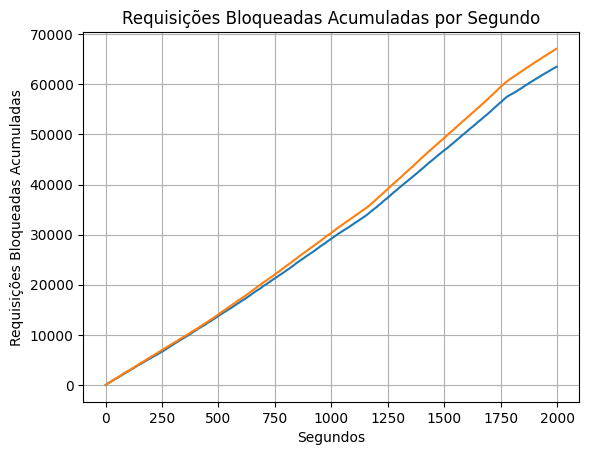

In [4]:

df_bloqueadas1 = dataframe1[dataframe1["bloqueada"] == True]
df_acumulado_por_segundo1 = df_bloqueadas1.groupby('tempo_criacao').size().cumsum()

df_bloqueadas2 = dataframe2[dataframe2["bloqueada"] == True]
df_acumulado_por_segundo2 = df_bloqueadas2.groupby('tempo_criacao').size().cumsum()

plt.plot(df_acumulado_por_segundo1.index, df_acumulado_por_segundo1.values, label=str(cenario1.lista_de_ISPs[0].roteamento_desastre))
plt.plot(df_acumulado_por_segundo2.index, df_acumulado_por_segundo2.values, label=str(cenario2.lista_de_ISPs[0].roteamento_desastre))

plt.xlabel('Segundos')
plt.ylabel('Requisições Bloqueadas Acumuladas')
plt.title('Requisições Bloqueadas Acumuladas por Segundo')
plt.grid(True)
plt.show()

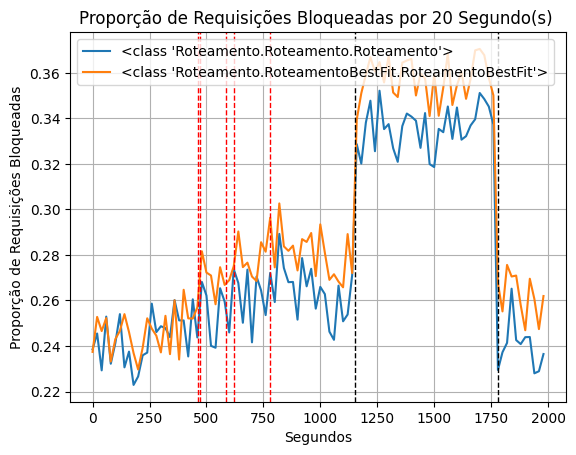

In [5]:
bucket_size = 20


segundos = (dataframe1['tempo_criacao'] // bucket_size) * bucket_size
total_requisicoes_por_segundo1 = dataframe1.groupby(segundos).size()
bloqueadas_por_segundo1 = dataframe1[dataframe1["bloqueada"] == True].groupby(segundos).size()
bloqueadas_por_segundo1 = bloqueadas_por_segundo1.reindex(total_requisicoes_por_segundo1.index, fill_value=0)
proporcao_bloqueadas1 = bloqueadas_por_segundo1 / total_requisicoes_por_segundo1
plt.plot(proporcao_bloqueadas1.index, proporcao_bloqueadas1.values, label=str(cenario1.lista_de_ISPs[0].roteamento_desastre))



segundos = (dataframe2['tempo_criacao'] // bucket_size) * bucket_size
total_requisicoes_por_segundo2 = dataframe2.groupby(segundos).size()
bloqueadas_por_segundo2 = dataframe2[dataframe2["bloqueada"] == True].groupby(segundos).size()
bloqueadas_por_segundo2 = bloqueadas_por_segundo2.reindex(total_requisicoes_por_segundo2.index, fill_value=0)
proporcao_bloqueadas2 = bloqueadas_por_segundo2 / total_requisicoes_por_segundo2
plt.plot(proporcao_bloqueadas2.index, proporcao_bloqueadas2.values, label=str(cenario2.lista_de_ISPs[0].roteamento_desastre))



#plota tempos de inicio de migração

tempos_de_inicio_migracao_ISP = [ (isp.datacenter.tempo_de_reacao, isp.id) for isp in cenario1.lista_de_ISPs] 

for x in tempos_de_inicio_migracao_ISP:
    plt.axvline(x=x[0], color='red', linestyle='--', linewidth=1)

inicio_desastre = cenario1.desastre.start
fim_desastre = cenario1.desastre.start + cenario1.desastre.duration

#plota inicio e fim do desastre
plt.axvline(x=inicio_desastre, color='black', linestyle='--', linewidth=1)
plt.axvline(x=fim_desastre, color='black', linestyle='--', linewidth=1)


plt.xlabel('Segundos')
plt.ylabel('Proporção de Requisições Bloqueadas')
plt.title(f'Proporção de Requisições Bloqueadas por {bucket_size} Segundo(s) ')
plt.grid(True)
plt.legend(loc = 'upper left')
plt.show()

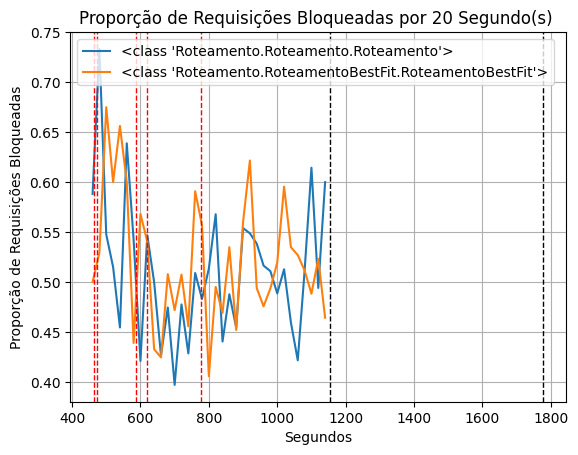

In [10]:
bucket_size = 20

dataframe1_migracao = dataframe1[dataframe1["requisicao_de_migracao"] == True]	
segundos = (dataframe1_migracao['tempo_criacao'] // bucket_size) * bucket_size
total_requisicoes_por_segundo1 = dataframe1_migracao.groupby(segundos).size()
bloqueadas_por_segundo1 = dataframe1_migracao[dataframe1_migracao["bloqueada"] == True].groupby(segundos).size()
bloqueadas_por_segundo1 = bloqueadas_por_segundo1.reindex(total_requisicoes_por_segundo1.index, fill_value=0)
proporcao_bloqueadas1 = bloqueadas_por_segundo1 / total_requisicoes_por_segundo1
plt.plot(proporcao_bloqueadas1.index, proporcao_bloqueadas1.values, label=str(cenario1.lista_de_ISPs[0].roteamento_desastre))


dataframe2_migracao = dataframe2[dataframe2["requisicao_de_migracao"] == True]
segundos = (dataframe2_migracao['tempo_criacao'] // bucket_size) * bucket_size
total_requisicoes_por_segundo2 = dataframe2_migracao.groupby(segundos).size()
bloqueadas_por_segundo2 = dataframe2_migracao[dataframe2_migracao["bloqueada"] == True].groupby(segundos).size()
bloqueadas_por_segundo2 = bloqueadas_por_segundo2.reindex(total_requisicoes_por_segundo2.index, fill_value=0)
proporcao_bloqueadas2 = bloqueadas_por_segundo2 / total_requisicoes_por_segundo2
plt.plot(proporcao_bloqueadas2.index, proporcao_bloqueadas2.values, label=str(cenario2.lista_de_ISPs[0].roteamento_desastre))



#plota tempos de inicio de migração

tempos_de_inicio_migracao_ISP = [ (isp.datacenter.tempo_de_reacao, isp.id) for isp in cenario1.lista_de_ISPs] 

for x in tempos_de_inicio_migracao_ISP:
    plt.axvline(x=x[0], color='red', linestyle='--', linewidth=1)

inicio_desastre = cenario1.desastre.start
fim_desastre = cenario1.desastre.start + cenario1.desastre.duration

#plota inicio e fim do desastre
plt.axvline(x=inicio_desastre, color='black', linestyle='--', linewidth=1)
plt.axvline(x=fim_desastre, color='black', linestyle='--', linewidth=1)


plt.xlabel('Segundos')
plt.ylabel('Proporção de Requisições Bloqueadas')
plt.title(f'Proporção de Requisições Bloqueadas por {bucket_size} Segundo(s) ')
plt.grid(True)
plt.legend(loc = 'upper left')
plt.show()

In [8]:
len(dataframe1[ (dataframe1["requisicao_de_migracao"] == True) & (dataframe2["bloqueada"] == True)])/len(dataframe1[ dataframe1["requisicao_de_migracao"] == True])

C:\Users\user\AppData\Local\Temp\ipykernel_7956\3926705390.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  len(dataframe1[ (dataframe1["requisicao_de_migracao"] == True) & (dataframe2["bloqueada"] == True)])/len(dataframe1[ dataframe1["requisicao_de_migracao"] == True])


0.27485380116959063